# <center>MNIST - Multiclass Classification of the MNIST digits dataset with a MLP using Tensorflow and Keras</center>
<center><img src="keras-tensorflow-logo.jpg"></center>

In this notebook, we will illustrate multi-class classification for the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) using a Multilayer Perceptron (MLP) (or ANN). 

The MNIST dataset is an image dataset of handwritten digits. It has has 60,000 training images and 10,000 test images, each of which are grayscale 28 x 28 pixels. It is a good beginner's dataset to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

In this notebook we will first develop a MLP using Tensorflow & then the same architecture will be developed using Keras (running with Tensorflow backend). I expect to see similar performance out of both networks.

In [31]:
%reload_ext autoreload
%autoreload 2

# imports & tweaks
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, time

# tweaks for numpy & plotting libraries
float_formatter = lambda x: '%.4f' % x
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(threshold=np.inf, suppress=True, precision=4, linewidth=2048)

plt.style.use("seaborn-colorblind")
plt.rcParams["figure.figsize"] = (8, 6)
sns.set_style("darkgrid")
#sns.set_context("talk")
sns.set_context(context='notebook', font_scale=1.25)
sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

# NOTE: Always use a seed for random number generators, so you get same results across runs
# you can use any number as the seed 
seed = 101
np.random.seed(seed)

## Loading & Pre-processing the Images
We will load the images from the `keras.datasets.mnist` package, using the `load_data()` function. Keras ships with several datasets, like MNIST, Fashion, CIFAR-10 etc., which we can leverage for learning ML techniques.

The following pre-processing steps will be applied:
* The image data (X's) will be converted to floats & scaled to values between 0.0 & 1.0
* The labels (y's) will be one-hot encoded to width of 10 (as we have 10 output classes corresponding to digits 0-9)
* The training set (`X_train, y_train`) will be shuffled & split into training & cross-validation sets using an 80:20 split - we have 60,000 training examples, which will be split into two sets of 48,000 and 12,000 images &amp; labels. 
* The images & label arrays will be appropriately reshaped - `images -> (num_samples, num_features)`, `labels -> (num_samples, num_classes)`
* We will also keep a copy of the test images & labels (i.e. of `X_test & y_test`) _before_ any preprocessing is applied. This is to help with data visualization of the _'original dataset'_.

In [32]:
def load_and_preprocess_data(debug=False):
    from keras.datasets.mnist import load_data
    from keras.utils import to_categorical
    
    (X_train, y_train), (X_test, y_test) = load_data()
    # keep an non pre-processed copy of X_test/y_test for visualization
    test_images, test_labels = X_test.copy(), y_test.copy()
    
    if debug:
        print('Before preprocessing:')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))
        print(' - test_images.shape = {}, test_labels.shape = {}'.format(test_images.shape, test_labels.shape))

    # scale the images to between 0-1 & one-hot encode labels to 10 output classes corresponding to digits 0-9
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    y_train = to_categorical(y_train, 10) 
    y_test = to_categorical(y_test, 10)
    
    # split the training set into test & cross-validation set (80:20 ratio)
    indexes = np.arange(X_train.shape[0])
    for _ in range(5): indexes = np.random.permutation(indexes)  # shuffle 5 times!
    X_train = X_train[indexes]
    y_train = y_train[indexes]
    val_count = int(0.20 * X_train.shape[0])
    X_val = X_train[:val_count]
    y_val = y_train[:val_count]
    X_train = X_train[val_count:]
    y_train = y_train[val_count:]
    
    # reshape the image arrays (make 2D arrays instead of 3D arrays)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1] * X_val.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2]))
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels)

In [33]:
def display_sample(sample_images, sample_labels, sample_predictions=None,
                   num_rows=5, num_cols=10, plot_title=None, fig_size=None):
    """ display a random selection of images & corresponding labels, optionally with predictions 
        The display is laid out in a grid of num_rows x num_col cells
        If sample_predictions are provided, then each cell's title displays the prediction (if it matches actual)
        or actual/prediction if there is a mismatch
    """
    assert sample_images.shape[0] == num_rows * num_cols
    
    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows,num_cols,figsize=((14, 9) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.30}, squeeze=True)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index], cmap="gray")

                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title("%s" % sample_labels[image_index])
                else:
                    # else check if prediction matches actual value
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = (sample_labels[image_index] == sample_predictions[image_index])
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = true_label
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        title = '%s/%s' % (true_label, pred_label)
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None: f.suptitle(plot_title)
    
        plt.show()
        plt.close()

In [34]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels) = \
    load_and_preprocess_data(debug=True)
print('After preprocessing: ')
print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
print(' - X_val.shape = {}, y_val.shape = {}'.format(X_val.shape, y_val.shape))
print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))
print(' - test_images.shape = {}, test_labels.shape = {}'.format(test_images.shape, test_labels.shape))

Before preprocessing:
 - X_train.shape = (60000, 28, 28), y_train.shape = (60000,)
 - X_test.shape = (10000, 28, 28), y_test.shape = (10000,)
 - test_images.shape = (10000, 28, 28), test_labels.shape = (10000,)
After preprocessing: 
 - X_train.shape = (48000, 784), y_train.shape = (48000, 10)
 - X_val.shape = (12000, 784), y_val.shape = (12000, 10)
 - X_test.shape = (10000, 784), y_test.shape = (10000, 10)
 - test_images.shape = (10000, 28, 28), test_labels.shape = (10000,)


Displaying a random sample of 50 images from dataset


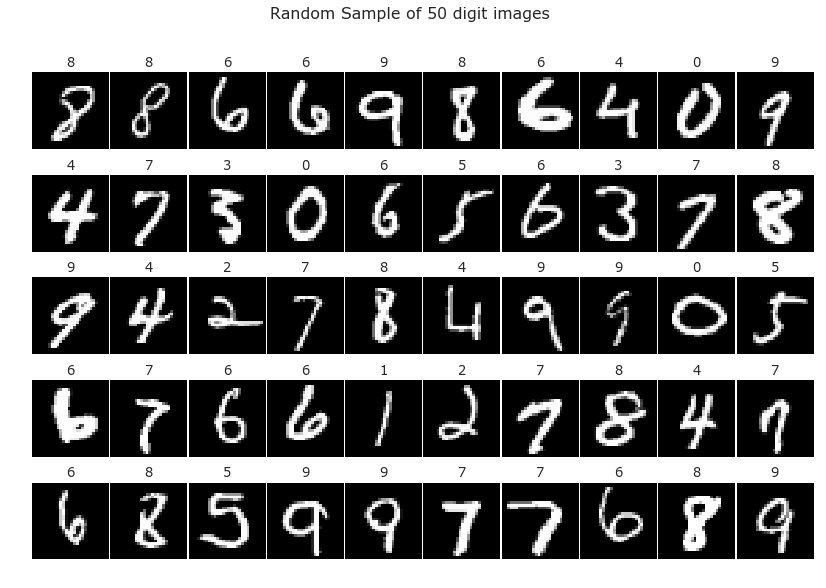

In [ ]:
# display a random sample of 50 digits
sample_size = 50
print('Displaying a random sample of {} images from dataset'.format(sample_size))
indexes = np.random.randint(0, test_images.shape[0], sample_size)
sample_images, sample_labels = test_images[indexes], test_labels[indexes]
display_sample(sample_images, sample_labels, sample_predictions=None, 
               num_rows=5, num_cols=10, plot_title="Random Sample of {} digit images".format(sample_size))

In [ ]:
# set some globals, which will be used across Tensorflow & Keras models
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_SIZE, NUM_CLASSES = 28, 28, 28*28, 10
MODEL_DIR, TF_MODEL_NAME, KR_MODEL_NAME = './model_states', 'tf_MNIST_mlp', 'kr_MNIST_mlp'
# the layout of our MLP
LAYER_DIMS = [IMAGE_HEIGHT * IMAGE_WIDTH, 512, 128, NUM_CLASSES]
# training parameters
NUM_EPOCHS, BATCH_SIZE = 50, 128
# for loading & saving model state
MODEL_SAVE_DIR, TF_MODEL_NAME, KR_MODEL_NAME = './model_states', 'tf_MNIST_mlp', 'kr_MNIST_mlp'

## Tensorflow Implementation
In this section, we will develop the MLP using Tensorflow. We have developed several utility functions to help with model development - training, evaluation, loading & saving model state, predictions. These functions are available in the Python code file `tf_nn_helper.py`, which is imported into this workbook.

### Building the Tensorflow Model
Our MLP is a 4 layer network (including the input & output layers) - we have 2 hidden layers with 512 & 128 nodes each. The input layer will have IMAGE_HEIGHT * IMAGE_WIDTH (i.e. 28 * 28) nodes, while the output layer will have 10 nodes (= to the number of output classes). We have defined a list LAYER_DIMS above, which holds the dimensions of each layer.

In [ ]:
import tensorflow as tf
tf.set_random_seed(seed)
import tf_nn_helper as tfu # Tensorflow utility functions for creating/training/evaluating/loading & saving TF models

In [ ]:
def initialize_parameters(layer_dims, debug=False):
    """ build the weights & biases for the network based on layout in LAYER_DIMS """
    weights, biases = {}, {}
    L = len(layer_dims)
    for l in range(1, L):
        weights['W' + str(l)] = tf.get_variable('W' + str(l),
                                                dtype=tf.float32,
                                                shape=(layer_dims[l-1], layer_dims[l]),
                                                initializer=tf.contrib.layers.xavier_initializer())
        biases['b' + str(l)] = tf.get_variable('b' + str(l),
                                                dtype=tf.float32,
                                                shape=(1, layer_dims[l]),
                                                initializer=tf.zeros_initializer())  
        
    if debug:
        # display weights & biases
        for i, w in enumerate(weights):
            print('weights[W{}] = {}'.format(i, weights['W' + str(i+1)]))
            print('biases[b{}] = {}'.format(i, biases['b' + str(i+1)]), flush=True)
    return weights, biases

In [ ]:
def build_tf_model(X, y, kp, layer_dims, debug=False):
    
    def build_tf_nn(A0, weights, biases):
        """ builds the network layers """
        A_prev = A0
        L = len(weights)
        for l in range(1, L):
            W, b = weights['W' + str(l)], biases['b' + str(l)]
            A = tfu.dense(A_prev, W, b, activation='relu', batch_normalize=False)
            A = tf.nn.dropout(A, keep_prob=kp)
            A_prev = A
        # output layer - this will have softmax activation for multi-class classification
        W, b = weights['W' + str(L)], biases['b' + str(L)]
        out = tfu.dense(A_prev, W, b, activation='softmax', batch_normalize=False)
        out = tfu.add_name_to_tensor(out, name='out')
        return out
    
    weights, biases = initialize_parameters(layer_dims, debug=debug)
    # our network tensors
    out = build_tf_nn(X, weights, biases)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=out), name='loss')
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss, name='train_op')
    correct_prediction = tf.equal(tf.argmax(out,axis=1), tf.argmax(y, axis=1))
    tfu.add_name_to_tensor(correct_prediction, 'correct_prediction')
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='acc')
    
  #  now collect all these tensors & operators into a dict, which we can conveniently pass around
  #  to the various utility functions we have created above
  #  NOTE: keys of the dicts must be names EXACTLY as shown below, else the helper functions won't work.
    model = {}
    #model['weights'] = weights
    #model['biases'] = biases
    model['out'] = out
    model['loss'] = loss
    #model['optimizer'] = optimizer
    model['train_op'] = train_op
    model['correct_prediction'] = correct_prediction
    model['accuracy'] = accuracy
    return model      

In [ ]:
def load_tf_model(sess, base_file_name='network', model_path='./model_states'):
    # following call will raise exception if it fails!
    tf_graph = tfu.load_tf_model(sess, base_file_name, model_path)
    
    # restore elements from graph
    X = tf_graph.get_tensor_by_name("X:0")
    y = tf_graph.get_tensor_by_name("y:0")
    kp = tf_graph.get_tensor_by_name("keep_prob:0")

    # restore model dict
    model = {}
    model['out'] = tf_graph.get_tensor_by_name("out:0")
    model['loss'] = tf_graph.get_tensor_by_name("loss:0")
    #model['optimizer'] = optimizer
    model['train_op'] = tf_graph.get_operation_by_name("train_op")
    model['correct_prediction'] = tf_graph.get_tensor_by_name("correct_prediction:0")
    model['accuracy'] = tf_graph.get_tensor_by_name("acc:0")
    return model, X, y, kp

### Training our Tensorflow Model
We will train our Tensorflow model through 50 epochs, using a batch size of 128. But we first need to create placeholders.

In [ ]:
def create_placeholders(debug=False):
    # NOTE: tf_nn_helper expects 2 place holders with name "X" and "y"
    # which is used to pass data to our model during training & evaluation
    X = tf.placeholder(dtype=tf.float32, name="X", shape=(None, IMAGE_HEIGHT * IMAGE_WIDTH))
    y = tf.placeholder(dtype=tf.float32, name="y", shape=(None, NUM_CLASSES))
    kp = tf.placeholder(dtype=tf.float32, name='keep_prob')
    if debug: print('Placeholders: X = {}, y = {}, kp={}'.format(X, y, kp), flush=True)
    return X, y, kp

In [ ]:
# build the model
tf.reset_default_graph()
X, y, kp = create_placeholders()
tf_model = build_tf_model(X, y, kp, LAYER_DIMS)
print(tf_model)

{'out': <tf.Tensor 'out:0' shape=(?, 10) dtype=float32>, 'loss': <tf.Tensor 'loss:0' shape=() dtype=float32>, 'train_op': <tf.Operation 'train_op' type=NoOp>, 'correct_prediction': <tf.Tensor 'Equal:0' shape=(?,) dtype=bool>, 'accuracy': <tf.Tensor 'acc:0' shape=() dtype=float32>}


In [ ]:
# train our model
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# def train_model(sess, model, data, labels, feed_dict=None, num_epochs=10, batch_size=32,
#                 validation_split=None, validation_data=None)
start_time = time.time()
feed_dict_train = {kp:(1.0-0.25)} # just pass in the keep probability placeholders
history = tfu.train_model(sess, tf_model, data=X_train, labels=y_train, feed_dict=feed_dict_train, 
                          num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))
end_time = time.time()
print('Trahttp://localhost:8892/notebooks/learning-ml/dl-tensorflow/MNIST%20-%20Multiclass%20Classification%20-%20MLP%20-%20with%20Tensorflow%20%26%20Keras.ipynb#ining completed in {}'.format(tfu.time_taken_as_str(start_time, end_time)))

Train on 48000 samples, validate with 12000 samples. Train for 50 epochs, with 376 batches per epoch.
Epoch 1/50:
  Training : Batch (192/375) [==============>...............] -> ETA: 4s - loss: 1.5313 - acc: 0.9453           

In [ ]:
tfu.show_plots(history)

### Evaluating performance of Tensorflow model
Let's evaluate performance of our model on training, cross-validation & test data.

In [ ]:
print('Evaluating performance:')
feed_dict_eval = {kp:(1.0)} # NO droput during evaluation!!
loss, acc = tfu.evaluate_model(sess, tf_model, X_train, y_train, feed_dict=feed_dict_eval, batch_size=BATCH_SIZE)
print(' - Training dataset: loss = {:.4f}, accuracy = {:.4f}'.format(loss, acc))

loss, acc = tfu.evaluate_model(sess, tf_model, X_val, y_val, feed_dict=feed_dict_eval, batch_size=BATCH_SIZE)
print(' - Cross-validation dataset: loss = {:.4f}, accuracy = {:.4f}'.format(loss, acc))

loss, acc = tfu.evaluate_model(sess, tf_model, X_test, y_test, feed_dict=feed_dict_eval, batch_size=BATCH_SIZE)
print(' - Test dataset: loss = {:.4f}, accuracy = {:.4f}'.format(loss, acc))

**Observations for Tensorflow Model:**
* We get a `training accuracy = 99.5%`, a `cross-validation accuracy = ~98%` and a `test accuracy = ~98%` with this model.
* Since the difference between training & cross-validation accuracy is not much, we can conclude the thet model is not overfitting the data much (only slightly!)
* The test accuracy is fairly good.

In [ ]:
# save the model state & close session
tfu.save_tf_model(sess, base_file_name=TF_MODEL_NAME, model_path=MODEL_SAVE_DIR)
del tf_model
sess.close()

### Making Predictions with the Tensorflow Model
Next we will run predictions with our Tensorflow model & view some random results. 

NOTE: Model structure (graph) & state (parameters) will be loaded from last saved state.

In [ ]:
tf.reset_default_graph()
sess = tf.Session()
tf_model, X, y, kp = load_tf_model(sess, base_file_name=TF_MODEL_NAME, model_path=MODEL_SAVE_DIR)
print('Loaded model')
print(tf_model)

In [ ]:
# this is the ground truth (reverse one-hot encode of test data)
y_true = np.argmax(y_test, axis=1)
y_true[:30]

In [ ]:
feed_dict_eval = {kp:(1.0)} # NO droput during evaluation!!
predictions = tfu.predict(sess, tf_model, X_test, feed_dict=feed_dict_eval) # no dropouts when running predictions
# reverse one-hot encode the predictions
y_pred = np.argmax(predictions, axis=1)
y_pred[:30]

In [ ]:
# display a random sample of 50 digits with predictions
# NOTE: the title of each cell shows the predicted value in green if prediction matches actual
# else cell title shows actual/predicted value in red font
sample_size = 50
print('Displaying a random sample of {} images from dataset'.format(sample_size))
indexes = np.random.randint(0, test_images.shape[0], sample_size)
sample_images, sample_labels, sample_predictions = test_images[indexes], test_labels[indexes], y_pred[indexes]
display_sample(sample_images, sample_labels, sample_predictions=sample_predictions, 
               num_rows=5, num_cols=10, 
               plot_title="Tensorflow - actual vs predicted - for random sample of {} images".format(sample_size))

In [ ]:
# close the Tensorflow session
sess.close()

## Keras Implementation
In this section, we will develop the same model using the Keras API. You will notice immediately that the code written in this section is much less & much cleaner. Keras takes care of most of the details we covered above.

In [ ]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
import kr_helper_funcs as kru

# clear the Tensorflow backend to get rid of any spurious graphs
K.clear_session()

In [ ]:
def build_keras_model(layer_dims):
    model = Sequential()
    model.add(Dense(layer_dims[1], activation='relu', input_shape=(layer_dims[0],)))
    model.add(Dropout(0.25))
    model.add(Dense(layer_dims[2], activation='relu'))
    model.add(Dropout(0.25))
    # output is softmax
    model.add(Dense(layer_dims[3], activation='softmax'))
    adam = optimizers.Adam(lr=0.001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])
    return model

In [ ]:
kr_model = build_keras_model(LAYER_DIMS)
print(kr_model.summary())

In [ ]:
# train the model
history = kr_model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

In [ ]:
# display plots of loss & accuracies
kru.show_plots(history.history)

In [ ]:
# evaluate performance against train/cross-val & test data
print('Evaluating performance of Keras model:')
loss, acc = kr_model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
print(' - Training dataset: loss = {:.4f}, accuracy = {:.4f}'.format(loss, acc))

loss, acc = kr_model.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
print(' - Cross-validation dataset: loss = {:.4f}, accuracy = {:.4f}'.format(loss, acc))

loss, acc = kr_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(' - Test dataset: loss = {:.4f}, accuracy = {:.4f}'.format(loss, acc))

**Observations for Keras Model:**
* We get a `training accuracy = 99.95 %`, a `cross-validation accuracy = ~98%` and a `test accuracy = ~98%` with this model. **These are similar to Tensorflow model performance! **
* Since the difference between training & cross-validation accuracy is not much, we can conclude the thet model is not overfitting the data much (only slightly!)
* The test accuracy is fairly good.

### Making Predictions with the Keras Model
Next we will run predictions with our Tensorflow model & view some random results.

In [ ]:
# this is the ground truth (reverse one-hot encode of test data)
y_true = np.argmax(y_test, axis=1)
y_true[:30]

In [ ]:
predictions = kr_model.predict(X_test)
# reverse one-hot encode the predictions
y_pred = np.argmax(predictions, axis=1)
y_pred[:30]

In [ ]:
# display a random sample of 50 digits with predictions
# NOTE: the title of each cell shows the predicted value in green if prediction matches actual
# else cell title shows actual/predicted value in red font
sample_size = 50
print('Displaying a random sample of {} images from dataset'.format(sample_size))
indexes = np.random.randint(0, test_images.shape[0], sample_size)
sample_images, sample_labels, sample_predictions = test_images[indexes], test_labels[indexes], y_pred[indexes]
display_sample(sample_images, sample_labels, sample_predictions=sample_predictions, 
               num_rows=5, num_cols=10, 
               plot_title="Keras - actual vs predicted - for random sample of {} images".format(sample_size))

# <center> -- END -- </center>